# NLP analysis of movie plots: preprocessing data and exploratory analysis

After collecting data we are going to run some preprocessing procedure and exploratory analysis.

## 0. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#removing warnings
import warnings
warnings.filterwarnings("ignore")

#preprocessing
from nltk.stem import WordNetLemmatizer
from nltk.corpus.reader.wordnet import VERB, NOUN, ADJ, ADV
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer

#saving data
import pickle

## 1. Loading data

Next step in our analysis is preprocessing data. Let's load scraped data from csv file

In [2]:
data = pd.read_csv('data/data.csv', index_col = 'tconst').iloc[:,1:]
data.sample(10)

,averageRating,numVotes,primaryTitle,plot
tconst,,,,
tt7369722,4.3,1764,The Sandman,NaN
tt0273719,6.0,3555,Shake It,NaN
tt2837336,4.3,3822,Amnesiac,NaN
tt0084266,6.3,4060,Dragon Lord,NaN
tt0066593,5.7,1428,You Can't Win 'Em All,The setting is the time of the Greco-Turkish W...
tt0040270,6.3,1867,The Dark Past,Police psychiatrist Dr. Andrew Collins (Lee J....
tt0043972,7.4,6355,The River,NaN
tt1273235,5.0,65167,A Serbian Film,Miloš is a semi-retired porn star who lives wi...
tt0066924,6.7,3213,The Case of the Scorpion's Tail,A widow named Lisa (Ida Galli) inherits a smal...


First of all, we delete the rows where plot was not scraped or too little information is scraped

In [3]:
data = data[~data['plot'].isna()]
data = data[data['plot'].str.len()>30]
data.sample(10)

,averageRating,numVotes,primaryTitle,plot
tconst,,,,
tt8108196,6.0,6677,Judgementall Hai Kya,Bobby is a strange wealthy young woman living ...
tt0047577,5.9,9937,This Island Earth,Dr. Cal Meacham is flying to his laboratory in...
tt0856052,7.2,1693,No Mercy for the Rude,A lonely chef with a speech impediment takes a...
tt11322920,8.0,8807,Ayyappanum Koshiyum,"Koshy Kurien, an ex-Havildar in Indian Army is..."
tt6878378,5.2,12440,Vivegam,An arms exchange deal happens between the Gene...
tt2301155,6.0,7056,Shootout at Wadala,"In a police van, Afaaque Baagwan listens to th..."
tt3702652,5.3,18390,The Other Side of the Door,"After losing her son Oliver, who drowned in a ..."
tt0032818,6.0,4291,The Mummy's Hand,"In Egypt, Andoheb travels to the Hill of the S..."
tt0075164,5.2,1940,Satan's Slave,The film focuses on a struggling family living...


In [4]:
data.shape

(16225, 4)

Sadly, we didn't find plot description of half of the movies. We end up with high dimensional low sample size data so we take this into consideration in order to run classical models and avoid overfitting

## 2. Preprocessing

<AxesSubplot:ylabel='Frequency'>

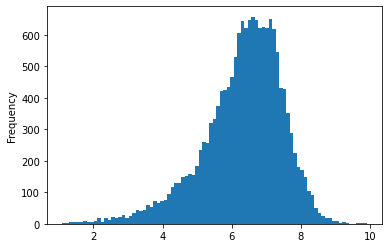

In [5]:
y = data['averageRating']
y.plot(kind='hist', bins = data['averageRating'].nunique())

Good news - our data is almost normally distributed which is one of the assumptions for linear regression. 

Running some preprocessing steps like selecting only words, not digits or punctuation, making them lowercase. We also lemmatize the words to avoid repeating the same word in different forms.

In [6]:
#remapping parts of speech for lemmatization
dict_pos_map = {
    'NN': NOUN,
    'VB':VERB,
    'JJ' : ADJ,
    'RB':ADV  
}

def Standardize(data):
    X = data.copy()
    X = X.str.replace(r"[^\w\s]", "", regex = True) #leaving only words
    X = X.str.replace('\d+', '', regex = True) #removing digits
    X = X.str.lower()
    wnl = WordNetLemmatizer()
    for i, val in enumerate(X):
        text_lem = ""
        tokens = word_tokenize(val)
        tokens_w_pos = pos_tag(tokens) #tagging words to further use lemmatizer, otherwise only considers them as nouns
        for w, pos in tokens_w_pos:
            if w in stop_words or pos not in dict_pos_map:
                continue #removing stop_words and other than noun, adj, verb, adv words
            text_lem += wnl.lemmatize(w, pos = dict_pos_map[pos])+" " #concatenating lemmatized text
        X[i] = text_lem
    return X

X = Standardize(data['plot'])
X[1]

'film similar length first part assassination abraham lincoln intermission new york premiere stage audience dramatic version clansman venue previously also none son confederate soldier direct film version clansman '

Tagging part of speech helped to lemmatize words. Now we can vectorize the cleaned text and run further analysis.

## 3. Exploratory analysis

For our problem we believe that binary count vectorization is the best option. it does not matter how often the word or the phrase is repeated in the plot but how often it appears in different movie descriptions. 

For better understanding of the data we try different ngram vectorizations from 1 word to 3. We tried different values of maximum and minimum document frequencies to remove too frequent and too rare words with zero predictive power.

In [7]:
def explore_data(ngram, max_df, min_df):
    vectorizer = CountVectorizer(ngram_range = ngram, max_df = max_df, min_df = min_df, binary=True)
    X_vect = vectorizer.fit_transform(X)
    plt.figure()
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12,12))
    
    words_in_movie = pd.DataFrame(X_vect.todense(), index=data['primaryTitle'], columns=vectorizer.get_feature_names())
    words_in_movie['count_words'] = words_in_movie.sum(axis=1)
    ax[0,1].hist(words_in_movie['count_words'], bins = words_in_movie['count_words'].max())
    ax[0,1].set_title('Movie distribution based on number of terms')
    
    movies_w_many_words = words_in_movie['count_words'].sort_values()[-20:]
    ax[0,0].barh(movies_w_many_words.index, movies_w_many_words)
    ax[0,0].set_title('Top 20 movies with largest number of terms')
    
    word_freq = pd.DataFrame(X_vect.todense().T, index=vectorizer.get_feature_names(), columns=data['primaryTitle'])
    word_freq['word_freq'] = word_freq.sum(axis=1)
    ax[1,1].hist(word_freq['word_freq'], bins = word_freq['word_freq'].max()-min_df)
    ax[1,1].set_title('Term frequency')
    
    frequent_words = word_freq['word_freq'].sort_values()[-20:]
    ax[1,0].barh(frequent_words.index, frequent_words)
    ax[1,0].set_title('Top 20 frequent terms')
    plt.suptitle('Plots for '+str(ngram)+'-gram vectorization' )
    plt.show()

First, we analyze one word vectorization. We need to limit maximum frequency to cut off some common words and at the same time limit minimum frequency to remove words that are only met at few movies.

<Figure size 432x288 with 0 Axes>

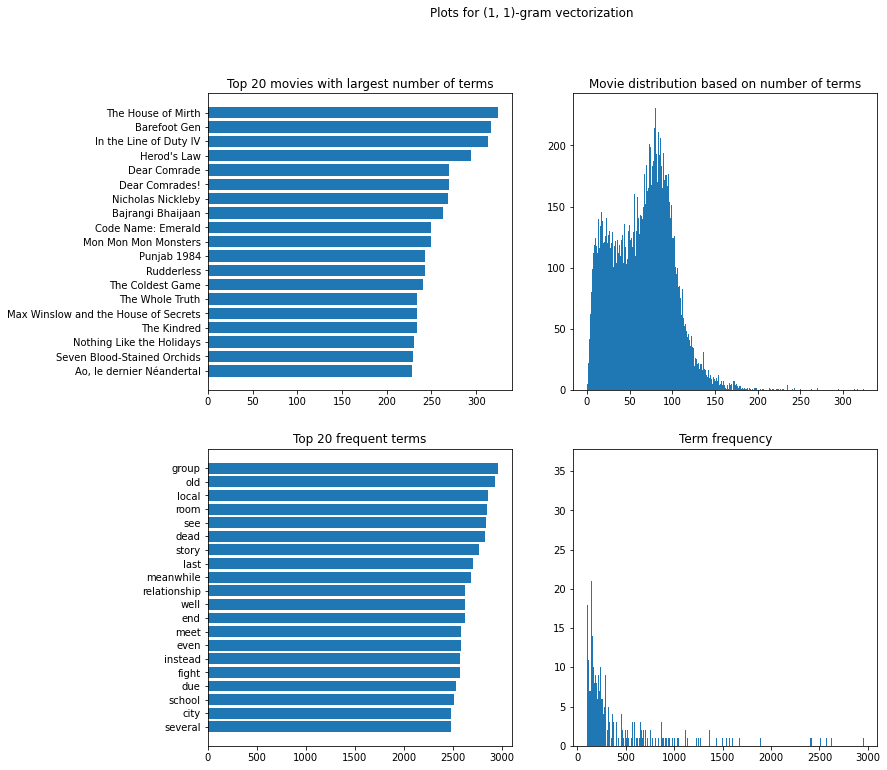

In [8]:
#one word
explore_data(ngram = (1,1), max_df = 3000, min_df = 100)

We can see that some movie plots include more than 300 words from the vectorization vocabulary. In average, a movie description contains from 50 to 100 words from the determined vocabulary. Looking at the most frequent words we can hardly get any insight about the movie. Among interesting frequent words we can indicate `dead`, `relationship`, `school` and `fight`. Probably, featurizing by two word phrases would be more useful, but we definitely reducing the document frequency of the features.

<Figure size 432x288 with 0 Axes>

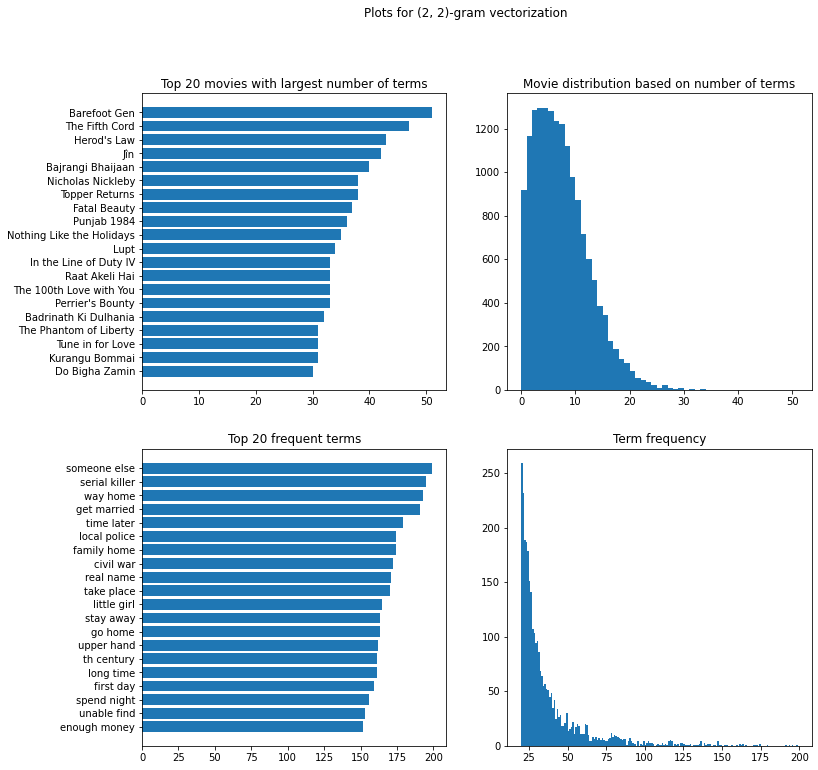

In [9]:
#two word phrases
explore_data(ngram = (2,2), max_df = 200, min_df = 20)

We reduce both document frequency parameters to get meaningful results. This time frequent terms give more information on the movie plot. For example, `serial killer` - probably some detectives or documention movies, `get married` - romantic films, `civil war` - war themed films, `th century` - probably history movies. Let's also analyze three word phrases.

<Figure size 432x288 with 0 Axes>

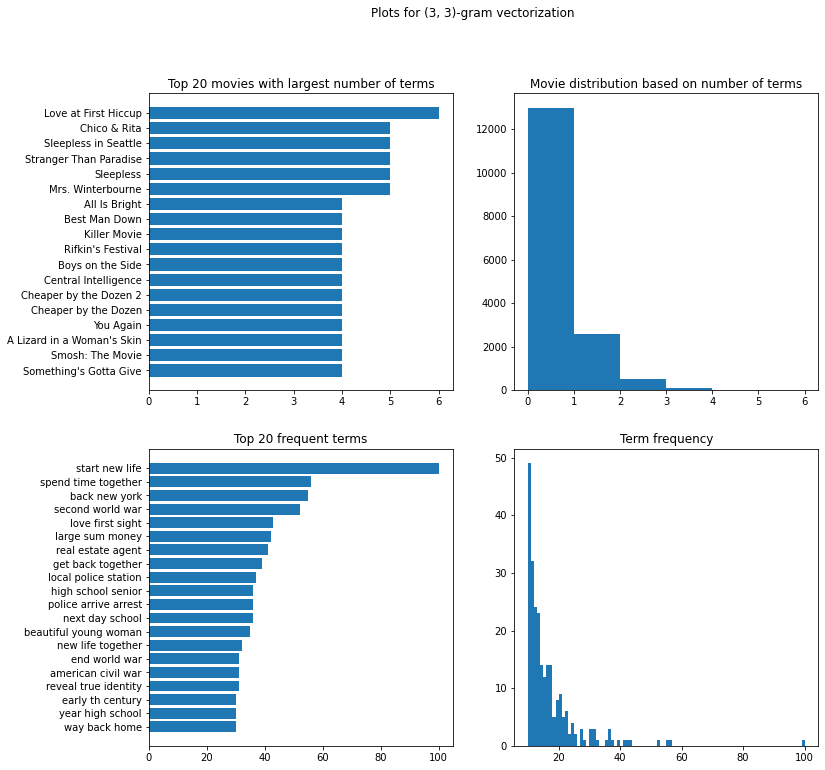

In [10]:
#three word phrases
explore_data(ngram = (3,3), max_df = 100, min_df = 10)

Three word vectorization made our data very sparse. The maximum ones we have in one row is 6. But now we have such features as `second world war`, `love first sight`, `large sum money` and so on. 

We believe the best option for further analysis is using 2 and 3 word phrases and drop one word features. 

In [11]:
vectorizer = CountVectorizer(ngram_range = (2,3), max_df = 200, min_df = 10, binary=True)
X_vect = vectorizer.fit_transform(X)
X_vect.shape

(16225, 10614)

We have arounf 10k features which is smaller than the sample size, but can still cause some problems when fitting models. 

Finally, we dump vectorized data as a pickle file to use it for building models.

In [12]:
pickle.dump(X_vect, open( "data/X_vect.p", "wb" ))
pickle.dump(y, open( "data/y.p", "wb" ))